In [557]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [558]:
import sys
sys.path.append("/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/utils")
import NeuGNN_model
import Self_func
import Interaction_func
from NeuGNN_model import *
from Self_func import *
from Interaction_func import *

In [559]:
USE_CUDA = False

In [560]:
Timeseries = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Time series/simulation_flocks_timeseries_20new.csv',encoding='utf-8',header=None)

In [561]:
Adj = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Topology/flocks_A_20new.csv',encoding='utf-8',header=None)

In [562]:
model = 'flocks'

In [563]:
Num_nodes = Adj.shape[0]
Dimension = 3

In [564]:
time = Timeseries.values
timeseries = time.reshape(( -1, Num_nodes, Dimension)) # checked, correct input data

In [565]:
delt_t = 0.01

In [566]:
timeseries_t0 = timeseries[0:-1,:,:]
timeseries_t1 = timeseries[1:,:,:]
dX = (timeseries_t1-timeseries_t0)
dXdt = (timeseries_t1-timeseries_t0)/delt_t

In [567]:
timeseries_t2 = timeseries[2:,:,:]
dVdt = (timeseries_t2-2*timeseries_t1[:-1,:,:]+timeseries[0:-2,:,:])/delt_t**2

In [568]:
import numpy as np
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

In [569]:
edge_index = get_edge_index(Adj) #target to source

index = [1,0]
edge_index = edge_index[index] #source to target 
# checked, correct input edge_index data

In [570]:
#data = data.reshape((10,-1,4,6))
import numpy as np
goal_data = np.concatenate([timeseries[3:,:,:],dXdt[1:-1,:,:],dVdt[:-1,:,:]],axis=2)
#goal_data = data[1:-1,:,0:Dimension]
mapping_data = np.concatenate((timeseries[1:-2,:,:],dXdt[0:-2,:,:]),axis=2)

In [571]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [572]:
from sklearn.model_selection import train_test_split

In [573]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [574]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [575]:
aggr = 'add'
hidden = 100


msg_dim = 3
n_f = mapping_data.shape[2]

In [576]:
dim = Dimension*1

In [577]:
from torch_geometric.data import Data, DataLoader

In [579]:
ogn = SDI_underdamp(model,n_f, msg_dim, dim, delt_t, hidden=hidden, edge_index=edge_index , aggr=aggr)

In [580]:
messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []
ogn = ogn

In [581]:
x=X_train[1]
y=y_train[1]
_q = Data(
    x=X_train[1],
    edge_index=edge_index,
    y=y_train[1])

In [582]:
ogn.loss(_q)

tensor(2454.8936, grad_fn=<AddBackward0>)

In [583]:
batch = 64
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=128,
    shuffle=True
)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [584]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [585]:
init_lr = 1e-4

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 20

batch_per_epoch = 2000

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

batch_per_epoch

2000

In [586]:
epoch = 0
from tqdm import tqdm

In [587]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

# newtestloader = DataLoader(
#     [Data(
#         X_train[i],
#         edge_index=edge_index,
#         y=y_train[i]) for i in test_idxes],
#     batch_size=len(X_train),
#     shuffle=False
# )

In [588]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source

        s2 = tmp.x[tmp.edge_index[1]] #target

        #Tmp = torch.cat([s2, s1],dim=1) # tmp --> xi,xj
        xtmp = s1[:,0:3]-s2[:,0:3]
        vtmp = s1[:,3:6]-s2[:,3:6]
        Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2+(s1[:,2]-s2[:,2])**2)
 
        cohesion = ogn.msg_fnc_cohesion(Xtmp.reshape(-1,1))*xtmp
        align = ogn.msg_fnc_align(Xtmp.reshape(-1,1))*vtmp
    
        all_messages = torch.cat((
            xtmp,vtmp,cohesion,align), dim=1)
        if dim == 1:
            columns = [elem%(k) for k in range(1,3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = ['xij','yij','zij','dxij','dyij','dzij','c1','c2','c3','a1','a2','a3']

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [589]:
def get_diffusion(ogn):
    def get_diffusion_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x), dim=1)
            columns = ['x','d1']
            
        if dim==2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y), dim=1)
            columns = ['x','y','d1','d2']
        if dim==3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y,self_diff_z), dim=1)
            columns = ['xi','yi','zi','dxi','dyi','dzi','d1','d2','d3']
            
        return pd.DataFrame(
              data=self_diff_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_diff_all)

    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))

    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info 

In [590]:
def get_selfDynamics(ogn):
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x), dim=1)
            columns = ['x','s1']
            
        if dim==2:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y), dim=1)
            columns = ['x','y','s1','s2']
        if dim==3:
            vtmp = torch.sqrt(tmp[:,3]**2+tmp[:,4]**2+tmp[:,5]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,3:6],self_dyn), dim=1)
            columns = ['dxi','dyi','dzi','s1']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info

In [591]:
recorded_models = []

In [592]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            loss = ogn.loss(ginput)
            loss.backward()
            #(loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    ogn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                if j>= batch_per_epoch:
                    break
                ginput.x = ginput.x
                ginput.y = ginput.y
                ginput.edge_index = ginput.edge_index
                ginput.batch = ginput.batch
                loss = ogn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1



    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(copy(ogn.state_dict()))

  0%|                                                    | 0/20 [00:00<?, ?it/s]

6267.35230447746
5832.00997025


  5%|██                                       | 1/20 [09:34<3:01:52, 574.33s/it]

5848.975403618154
5625.193354875


 10%|████                                     | 2/20 [19:08<2:52:11, 573.95s/it]

5607.921689994099
5496.44630325


 15%|██████▏                                  | 3/20 [28:44<2:42:53, 574.93s/it]

5502.806010994357
5472.25135225


 20%|████████▏                                | 4/20 [38:20<2:33:30, 575.64s/it]

5472.796210199918
5466.83024575


 25%|██████████▎                              | 5/20 [47:58<2:24:03, 576.25s/it]

5462.777413234065
5462.92567825


 30%|████████████▎                            | 6/20 [57:35<2:14:31, 576.51s/it]

5459.750391870584
5471.114991625


 35%|█████████████▋                         | 7/20 [1:07:13<2:05:00, 576.98s/it]

5457.172501699856
5466.003562875


 40%|███████████████▌                       | 8/20 [1:16:51<1:55:30, 577.58s/it]

5454.593764776049
5458.7612555


 45%|█████████████████▌                     | 9/20 [1:26:32<1:46:04, 578.57s/it]

5453.244074682303
5459.15409025


 50%|███████████████████                   | 10/20 [1:36:08<1:36:17, 577.71s/it]

5451.1766624398215
5459.024423875


 55%|████████████████████▉                 | 11/20 [1:45:53<1:27:00, 580.05s/it]

5450.734902541578
5458.907322375


 60%|██████████████████████▊               | 12/20 [1:55:31<1:17:14, 579.30s/it]

5449.366880866458
5462.298784125


 65%|████████████████████████▋             | 13/20 [2:05:12<1:07:38, 579.81s/it]

5448.35464397782
5461.6700135


 70%|████████████████████████████            | 14/20 [2:14:48<57:52, 578.67s/it]

5447.758496594426
5457.888999625


 75%|██████████████████████████████          | 15/20 [2:24:30<48:17, 579.59s/it]

5446.794759704811
5457.470468375


 80%|████████████████████████████████        | 16/20 [2:34:14<38:43, 580.97s/it]

5446.309263190493
5457.518518625


 85%|██████████████████████████████████      | 17/20 [2:43:52<29:00, 580.02s/it]

5445.81430853953
5457.462458


 90%|████████████████████████████████████    | 18/20 [2:53:33<19:20, 580.36s/it]

5445.348854086884
5457.4446405


 95%|██████████████████████████████████████  | 19/20 [3:03:09<09:39, 579.12s/it]

5445.197829557178
5457.44762975


100%|████████████████████████████████████████| 20/20 [3:12:57<00:00, 578.88s/it]


In [593]:
ogn.cpu()
ogn.load_state_dict(recorded_models[-1])

<All keys matched successfully>

In [594]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))
x_Update = []
y_Update = []
z_Update = []
for i in range(2000):#X.shape[0]
    _q = Data(
        x=X[i].float(),
        edge_index=edge_index,
        y=y[i].float())
    x_tmp,v_tmp= ogn.average_trajectories(_q)
    if i < X.shape[0]-2:
        X[i+2,:,0:3] = x_tmp
        
        X[i+1,:,3:6] = v_tmp
    else:
        break
    x_Update.append(x_tmp[:,0].reshape(1,-1))
    y_Update.append(x_tmp[:,1].reshape(1,-1))
    z_Update.append(x_tmp[:,2].reshape(1,-1))   
x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)

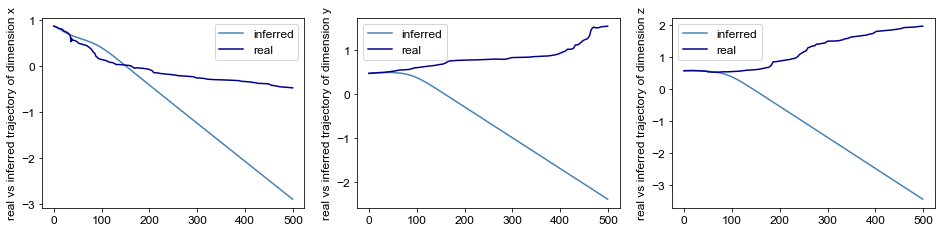

In [595]:
time1 = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/vicsek_model/flocks_timeseries_20new.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
#plt.rcParams['savefig.dpi'] = 300 
#plt.rcParams['figure.dpi'] = 300
Nindex = 0
TIME = 500
x_tra = x_i.detach().numpy()[0:TIME,Nindex-1]
x_real = time1.iloc[1:,Nindex*3-3]
fig = plt.figure(figsize=(16,3.5))
ax1 = fig.add_subplot(1,3,1)
t = np.arange(0,x_tra.shape[0])
ax1.plot(t,x_tra,c='steelblue',label="inferred")
ax1.plot(t, x_real[2:x_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1,3,2)
y_tra = y_i.detach().numpy()[0:TIME,Nindex-1]
y_real = time1.iloc[1:,Nindex*3-2]
t = np.arange(0,y_tra.shape[0])
ax2.plot(t,y_tra,c='steelblue',label="inferred")
ax2.plot(t, y_real[2:y_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()

ax3 = fig.add_subplot(1,3,3)
z_tra = z_i.detach().numpy()[0:TIME,Nindex-1]
z_real = time1.iloc[1:,Nindex*3-1]
t = np.arange(0,z_tra.shape[0])
ax3.plot(t,z_tra,c='steelblue',label="inferred")
ax3.plot(t, z_real[2:z_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension z')
plt.legend()
#plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_average_trajectories.png')
plt.show()
#plt.close()

/var/folders/tx/qq1ds3m144q1b4ghn62l4kjc0000gn/T/ipykernel_22964/1822499925.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


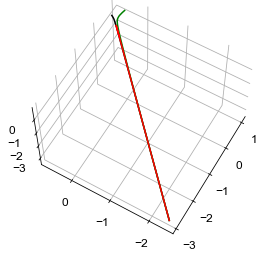

In [596]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.azim = -150
ax.dist = 9
ax.elev = 60
r = np.linspace(0, 5, 500)

x_tra_1 = x_i.detach().numpy()[0:TIME,Nindex+1]
y_tra_1 = y_i.detach().numpy()[0:TIME,Nindex+1]
z_tra_1 = z_i.detach().numpy()[0:TIME,Nindex+1]
x = x_tra_1#x_real[1:x_tra.shape[0]+1,]
y = y_tra_1 #y_real[1:y_tra.shape[0]+1,]
z = z_tra_1#z_real[1:z_tra.shape[0]+1,]

x_tra_2 = x_i.detach().numpy()[0:TIME,Nindex+2]
y_tra_2 = y_i.detach().numpy()[0:TIME,Nindex+2]
z_tra_2 = z_i.detach().numpy()[0:TIME,Nindex+2]
x2 = x_tra_2#x_real[1:x_tra.shape[0]+1,]
y2 = y_tra_2 #y_real[1:y_tra.shape[0]+1,]
z2 = z_tra_2#z_real[1:z_tra.shape[0]+1,]

x_tra_3 = x_i.detach().numpy()[0:TIME,Nindex+3]
y_tra_3 = y_i.detach().numpy()[0:TIME,Nindex+3]
z_tra_3 = z_i.detach().numpy()[0:TIME,Nindex+3]
x3 = x_tra_3#x_real[1:x_tra.shape[0]+1,]
y3 = y_tra_3 #y_real[1:y_tra.shape[0]+1,]
z3 = z_tra_3#z_real[1:z_tra.shape[0]+1,]


#1 colored by value of `z`
ax.plot3D(x, y, z, c = 'k') 
ax.plot3D(x2, y2, z2, c = 'g') 
ax.plot3D(x3, y3, z3, c = 'r') 
#2 colored by index (same in this example since z is a linspace too)

#ax.scatter(x1, y1, z1, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 3)#plt.cm.YlGnBu(r/max(r))

plt.show()

In [597]:
best_message = messages_over_time[-1]

In [598]:
best_message

,xij,yij,zij,dxij,dyij,dzij,c1,c2,c3,a1,a2,a3,epoch,loss
0,-0.004503,0.074400,-0.038042,-1.191634,0.304201,1.017380,-0.006469,0.106869,-0.054644,-1.131529,0.288857,0.966064,19,5445.19783
1,-0.042431,0.109920,-0.030367,-0.331897,0.366223,0.029542,-0.061665,0.159748,-0.044133,-0.308695,0.340621,0.027477,19,5445.19783
2,-0.121783,0.104935,-0.008270,-0.341404,0.845130,-0.009846,-0.180800,0.155787,-0.012278,-0.310663,0.769031,-0.008960,19,5445.19783
3,0.082572,0.141226,-0.139988,0.038680,-0.044815,-0.035667,0.127152,0.217474,-0.215567,0.035555,-0.041194,-0.032785,19,5445.19783
4,0.115723,0.042654,0.008698,-0.136141,0.919510,0.149316,0.168284,0.062026,0.012648,-0.126487,0.854303,0.138728,19,5445.19783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379995,-0.106304,0.103588,-0.040291,-0.626580,-0.158037,-0.233628,-0.157045,0.153032,-0.059522,-0.572462,-0.144387,-0.213449,19,5445.19783
379996,-0.000179,-0.053591,0.057474,-0.287389,-0.005730,-0.016514,-0.000257,-0.076856,0.082425,-0.273644,-0.005456,-0.015724,19,5445.19783
379997,-0.029257,0.138772,0.194244,-0.020135,-0.252533,-0.146066,-0.045806,0.217270,0.304121,-0.019108,-0.239659,-0.138620,19,5445.19783
379998,-0.030910,0.172115,0.113346,-0.154565,-0.641010,-0.322594,-0.047381,0.263825,0.173742,-0.140811,-0.583971,-0.293889,19,5445.19783


In [599]:
bestMe = messages_over_time[-1]

In [600]:
#bestMe.to_csv('message_vicsek.csv')

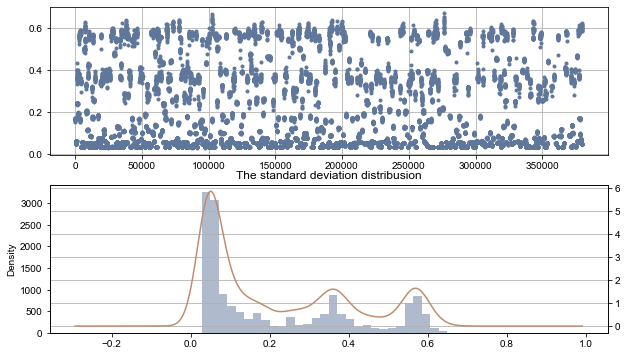

In [601]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

s = diffusion_new['d3'] # diffusion is sqrt(h)*theta(x0) 

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1)
#ax1.scatter(s.index, s.values)
ax1.plot(s.index, s.values,'.')
plt.grid()
 
ax2 = fig.add_subplot(2,1,2) 
s.hist(bins=30,alpha = 0.5,ax = ax2)
s.plot(kind = 'kde', secondary_y=True,ax = ax2)
plt.title('The standard deviation distribusion')
plt.grid()

In [602]:
diffusion_new

,xi,yi,zi,dxi,dyi,dzi,d1,d2,d3
0,-2.788593,-5.334840,18.576212,-0.235283,-1.276551,0.159030,0.347875,0.658772,0.169739
19,-2.793096,-5.260440,18.538170,-1.426917,-0.972350,1.176410,1.855073,0.466488,0.157939
38,-2.831023,-5.224921,18.545845,-0.567180,-0.910328,0.188572,0.604514,0.450190,0.165511
57,-2.910376,-5.229906,18.567942,-0.576687,-0.431421,0.149184,0.604534,0.226399,0.161959
76,-2.706021,-5.193614,18.436224,-0.196603,-1.321365,0.123363,0.291288,0.688354,0.173195
...,...,...,...,...,...,...,...,...,...
379905,-14.727405,-8.065665,25.662127,-0.507994,-0.017695,0.647711,0.930016,0.024363,0.048287
379924,-14.756482,-7.873302,25.798897,-0.240740,-0.264498,0.518159,0.623052,0.136571,0.049083
379943,-14.758136,-7.839960,25.717999,-0.375170,-0.652975,0.341631,0.588189,0.328825,0.049556
379962,-14.742022,-7.977930,25.710968,-0.490858,-0.185269,0.228868,0.602464,0.080103,0.048907


In [632]:

s = diffusion_new['d1'].values
s1 = np.abs(diffusion_new['dxi'].values)
s2 = diffusion_new['d2'].values
s3 = np.abs(diffusion_new['dyi'].values)
s4 = diffusion_new['d3'].values
s5 = np.abs(diffusion_new['dzi'].values)

In [534]:
s4

array([0.692704  , 0.6927176 , 0.6927079 , ..., 0.6926698 , 0.69267267,
       0.692675  ], dtype=float32)

In [633]:
import seaborn as sns
import numpy as np
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
 
sns.set_palette('deep', desat=.6)
sns.set_context(rc={'figure.figsize': (8, 5) } )
np.random.seed(1425)

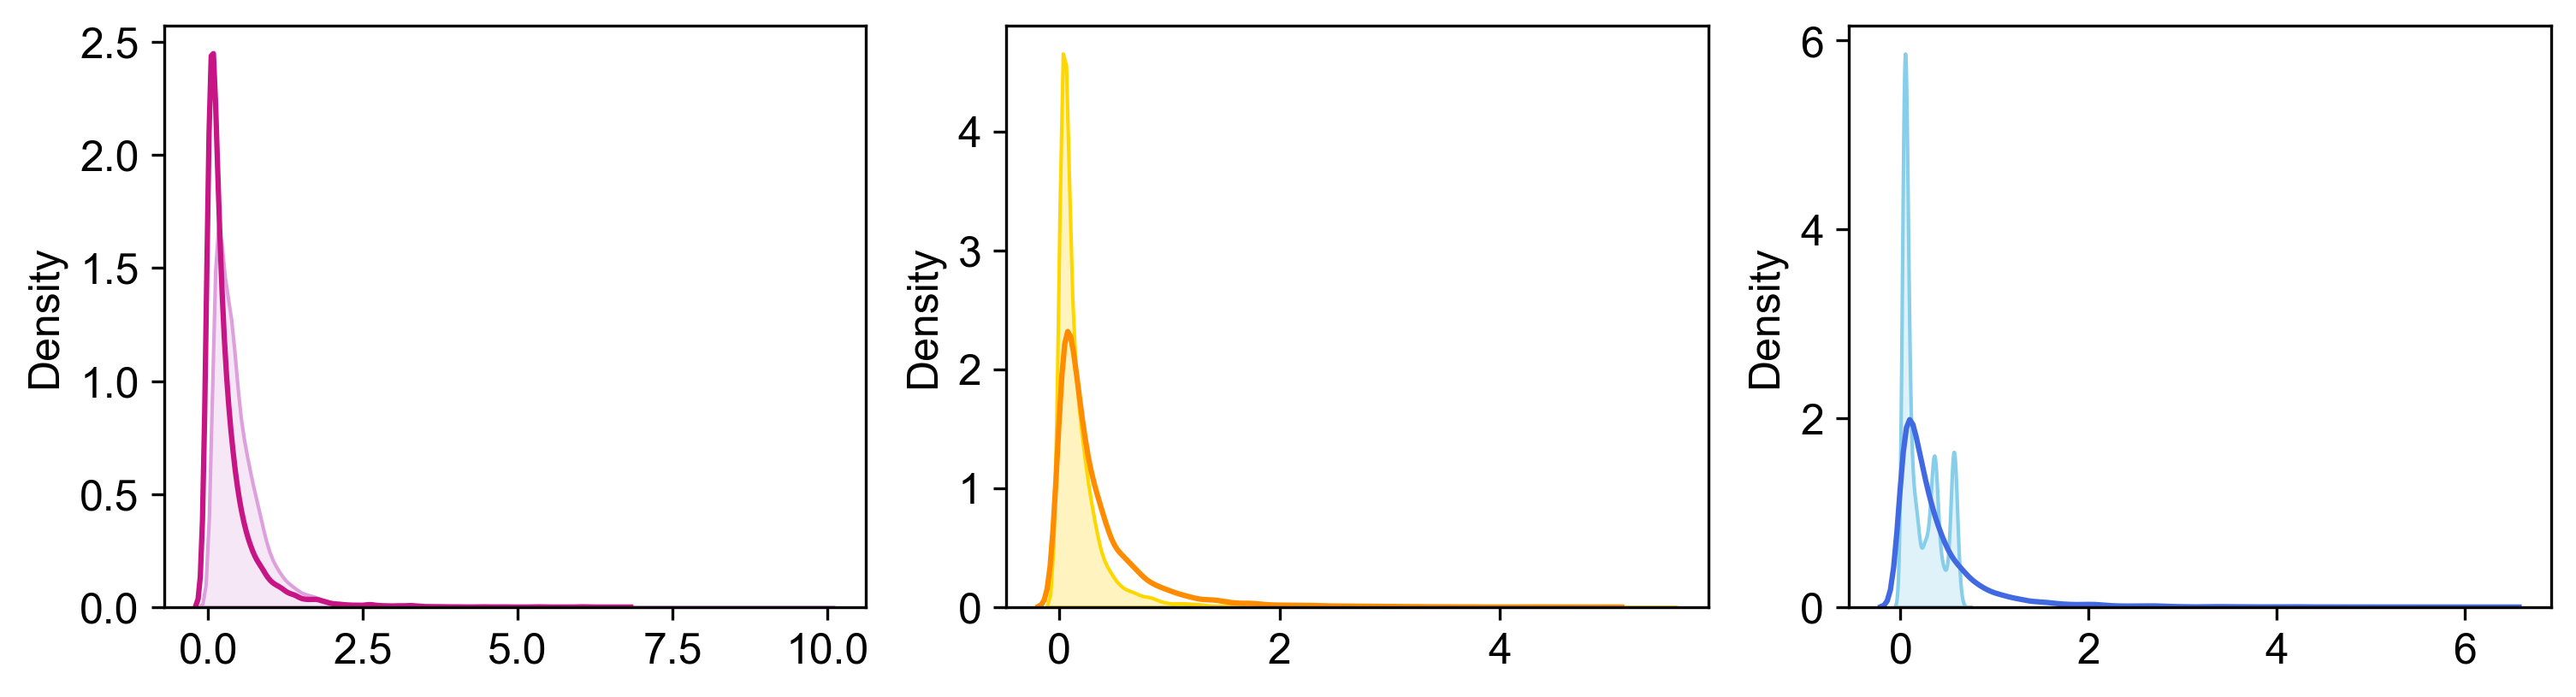

In [635]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(12, 3))
c1, c2, c3 = sns.color_palette('Set1', 3)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

sns.kdeplot(s, shade=True, color=colors['plum'], label='dist1', ax=ax1)
sns.kdeplot(s2, shade=True, color=colors['gold'], label='dist1', ax=ax2)
sns.kdeplot(s4, shade=True, color=colors['skyblue'], label='dist1', ax=ax3)
sns.kdeplot(s1, shade=False, color=colors['mediumvioletred'], label='dist2',ax=ax1)
sns.kdeplot(s3, shade=False, color=colors['darkorange'], label='dist2',ax=ax2)
sns.kdeplot(s5, shade=False, color=colors['royalblue'], label='dist2',ax=ax3)
#plt.xlim([-0.3, 2])
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/vicsek_model/Figures/vicsek_diffusion_fig.pdf')

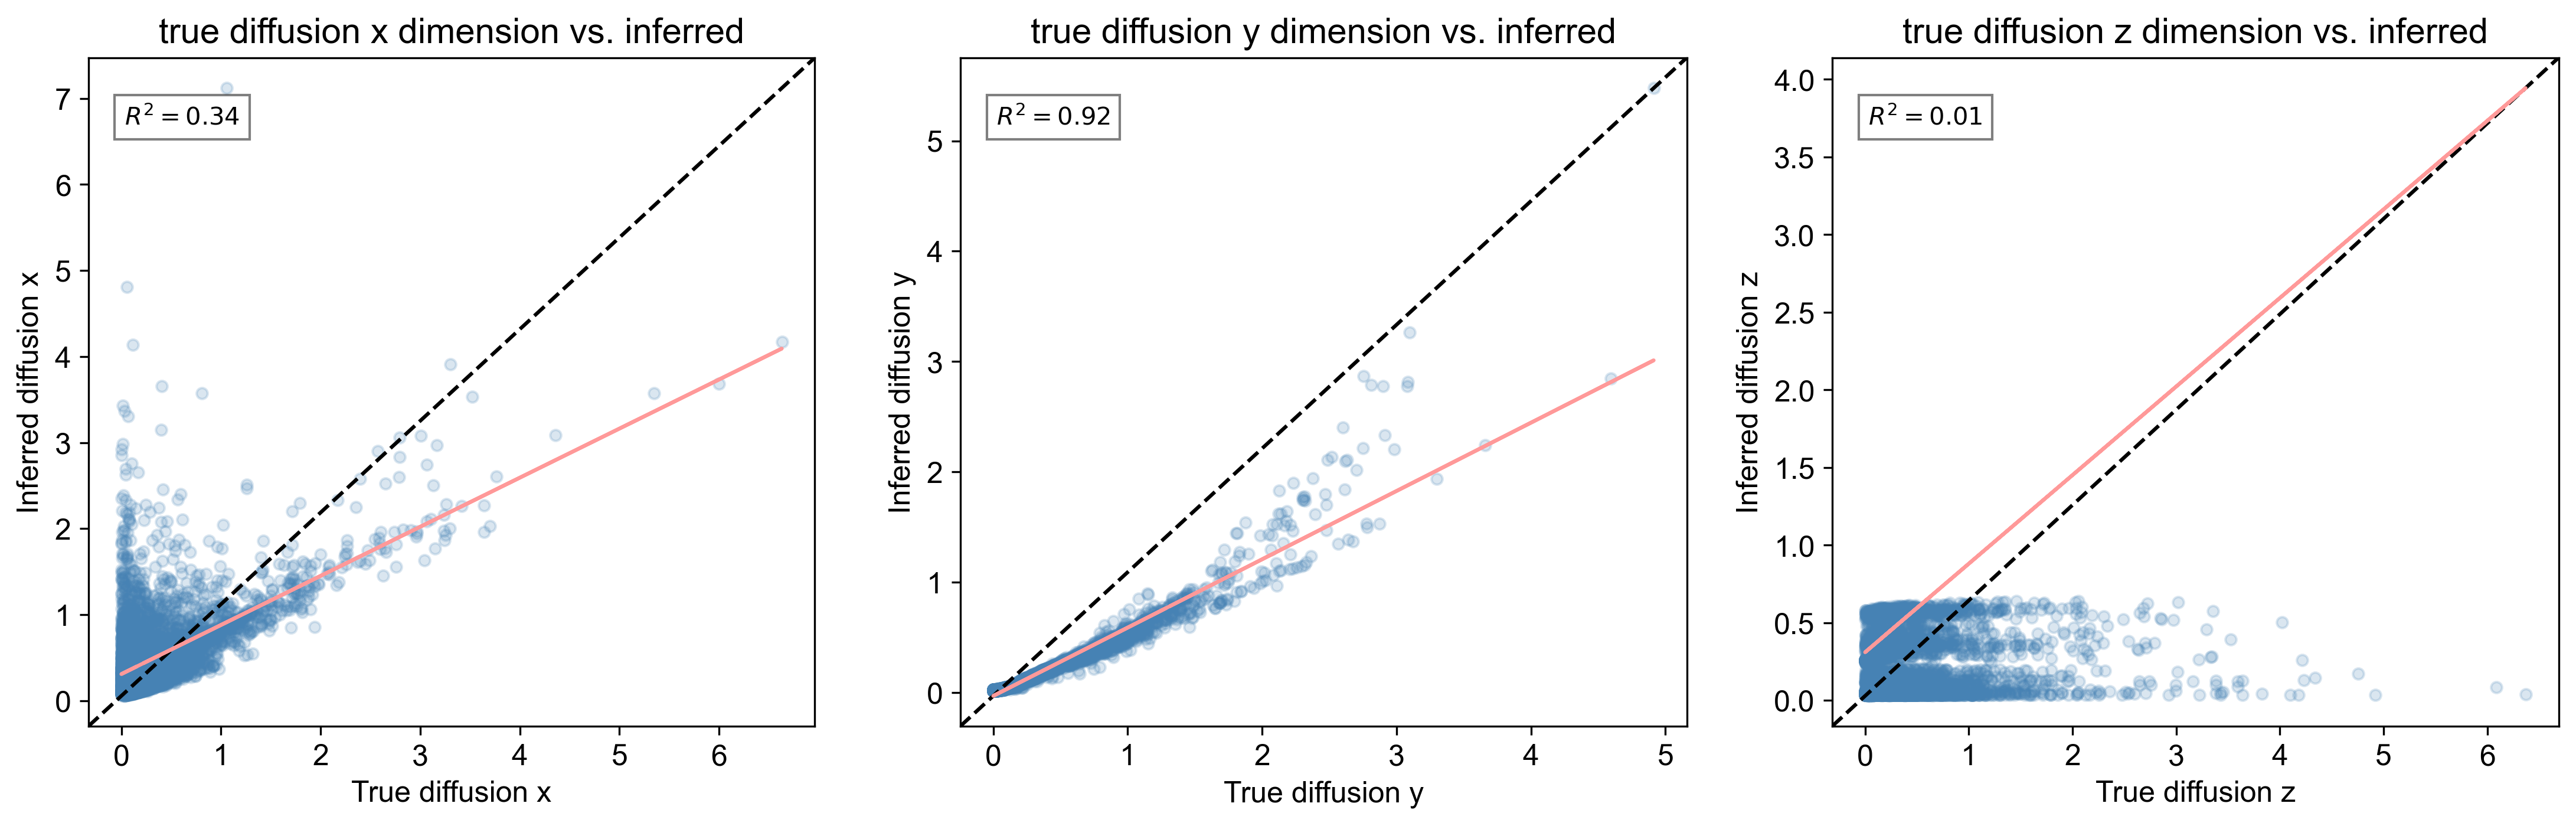

In [626]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#import seaborn as sb
eta = 0.1
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
sx = s
sx_true = s1
sy = s2
sy_true = s3
sz = s4
sz_true = s5

sx = sx[0:5000]
sx_true = sx_true[0:5000]
sy = sy[0:5000]
sy_true = sy_true[0:5000]
sz = sz[0:5000]
sz_true = sz_true[0:5000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true diffusion x dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c = '#ff9999', lw=1.5)

ax1.scatter(sx_true,sx,s=20,c ='steelblue', alpha=0.2)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion x")
plt.ylabel("Inferred diffusion x")
#plt.xlim((0, 2))
#plt.ylim((0, 2))
ax2 = fig.add_subplot(1,3,2)
plt.title("true diffusion y dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c = '#ff9999', lw=1.5)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion y")
plt.ylabel("Inferred diffusion y")
#plt.xlim((0, 2))
#plt.ylim((0, 2))
ax3 = fig.add_subplot(1,3,3)
plt.title("true diffusion z dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=20,c ='steelblue', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fx(sz_true),c = '#ff9999', lw=1.5)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion z")
plt.ylabel("Inferred diffusion z")
#plt.xlim((0, 5))
#plt.ylim((0, 5))
#plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_diffusion.png')
plt.show()
plt.close()

In [606]:
import Self_func
import Interaction_func

In [607]:
from Self_func import *
from Interaction_func import *

In [608]:
rij_val = np.sqrt(bestMe['xij']**2+bestMe['yij']**2+bestMe['zij']**2)
cohesion_true = 1.5*(1-(rij_val/2)**3)/(1+(rij_val/2)**6) # x1 (x_i) is target, x2 (x_j) is source 
align_true = np.exp(-rij_val/3)#np.sin(bestMe['x2'].values-bestMe['x1'].values)

In [609]:
# plt.rcParams.update({'font.size': 10}) 
# plt.rcParams.update({'font.style': 'normal'})
# plt.rcParams.update({'font.family': 'Arial'})

# #temp = bestMe['c1'].values#*bestMe['zij']+bestMe['a1'].values*bestMe['dzij']
# #coup_value = cohesion_true#*bestMe['zij']+align_true*bestMe['dzij']

# temp = bestMe['c1'].values#*bestMe['zij']+bestMe['a1'].values*bestMe['dzij']
# coup_value = cohesion_true#*bestMe['zij']+align_true*bestMe['dzij']

# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(1,1,1)
# ax.scatter(coup_value,temp,s=20,c ='steelblue', alpha=0.2)
# ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
# parameter = np.polyfit(coup_value,temp,1)
# f = np.poly1d(parameter)
# ax.plot(coup_value,f(coup_value),c = '#ff9999', lw=1.5)
# corr = np.corrcoef(coup_value,temp)[0,1]
# bbox = dict(fc='1',alpha=0.5)
# plt.xlim((0.5, 1.1))
# plt.ylim((0.5, 1.1))
# plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2),transform=ax.transAxes, size=12, bbox=bbox)
# plt.title('Relation-Vecsek-z')
# plt.xlabel("True coupling values")
# plt.ylabel("Inferred value from message passing layer")

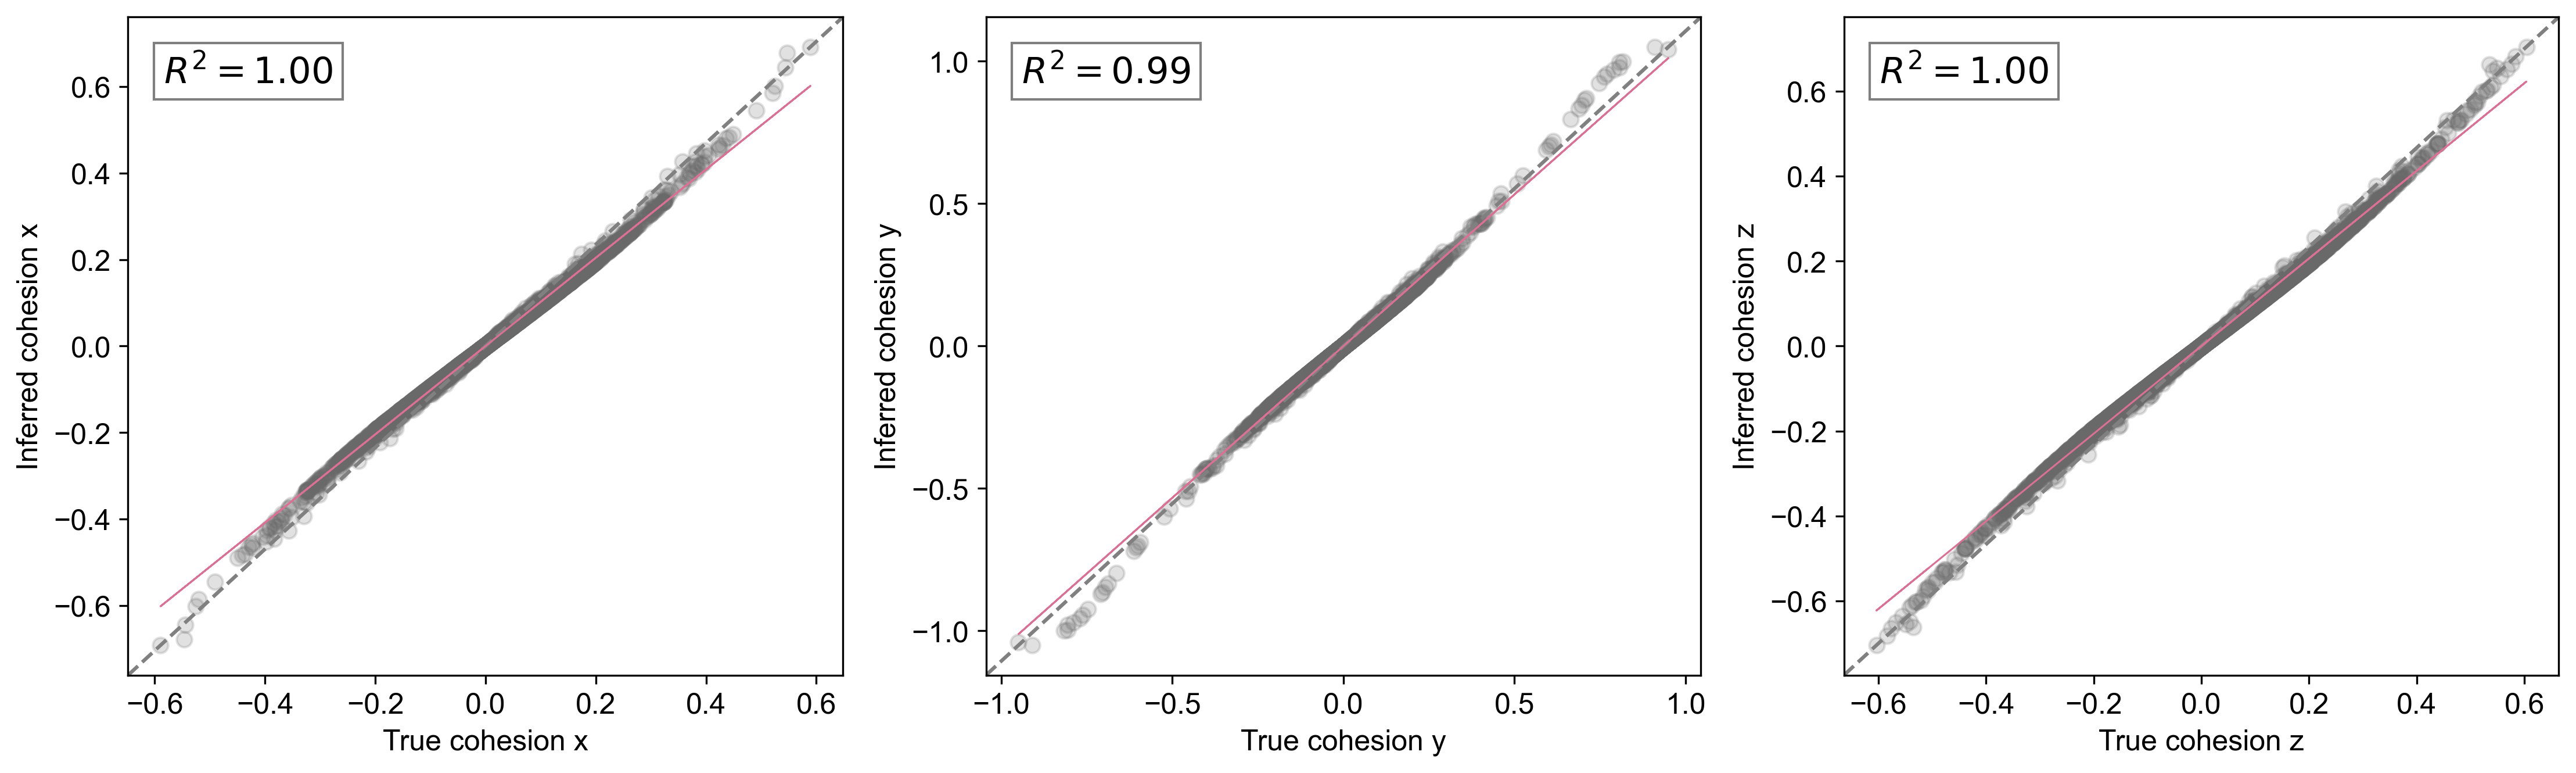

In [638]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sx = bestMe['c1'].values
sx_true = cohesion_true*bestMe['xij']
sy = bestMe['c2'].values
sy_true = cohesion_true*bestMe['yij']
sz = bestMe['c3'].values
sz_true = cohesion_true*bestMe['zij']

sx = sx[0:5000]
sx_true = sx_true[0:5000]
sy = sy[0:5000]
sy_true = sy_true[0:5000]
sz = sz[0:5000]
sz_true = sz_true[0:5000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=40,c ='dimgrey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='grey', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=0.75)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True cohesion x")
plt.ylabel("Inferred cohesion x")

ax2 = fig.add_subplot(1,3,2)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=40,c ='dimgrey', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='grey', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c='palevioletred',lw=0.75)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True cohesion y")
plt.ylabel("Inferred cohesion y")


ax3 = fig.add_subplot(1,3,3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=40,c ='dimgrey', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='grey', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fz(sz_true),c='palevioletred',lw=0.75)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=15, bbox=bbox)
plt.xlabel("True cohesion z")
plt.ylabel("Inferred cohesion z")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/vicsek_model/Figures/vicsek_cohesion_fig.pdf')

In [628]:
from sklearn.linear_model import LinearRegression 
sx_true = (1-(rij_val/2)**3)/(1+(rij_val/2)**6)*bestMe['yij'].values
goal = bestMe['c2'].values.reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['c2'])
y = goal.copy()
Xfind = sx_true.values.reshape(-1,1)
yfind = y['c2']
model_linear = LinearRegression(fit_intercept=False)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_
print(a)

[1.5326148]


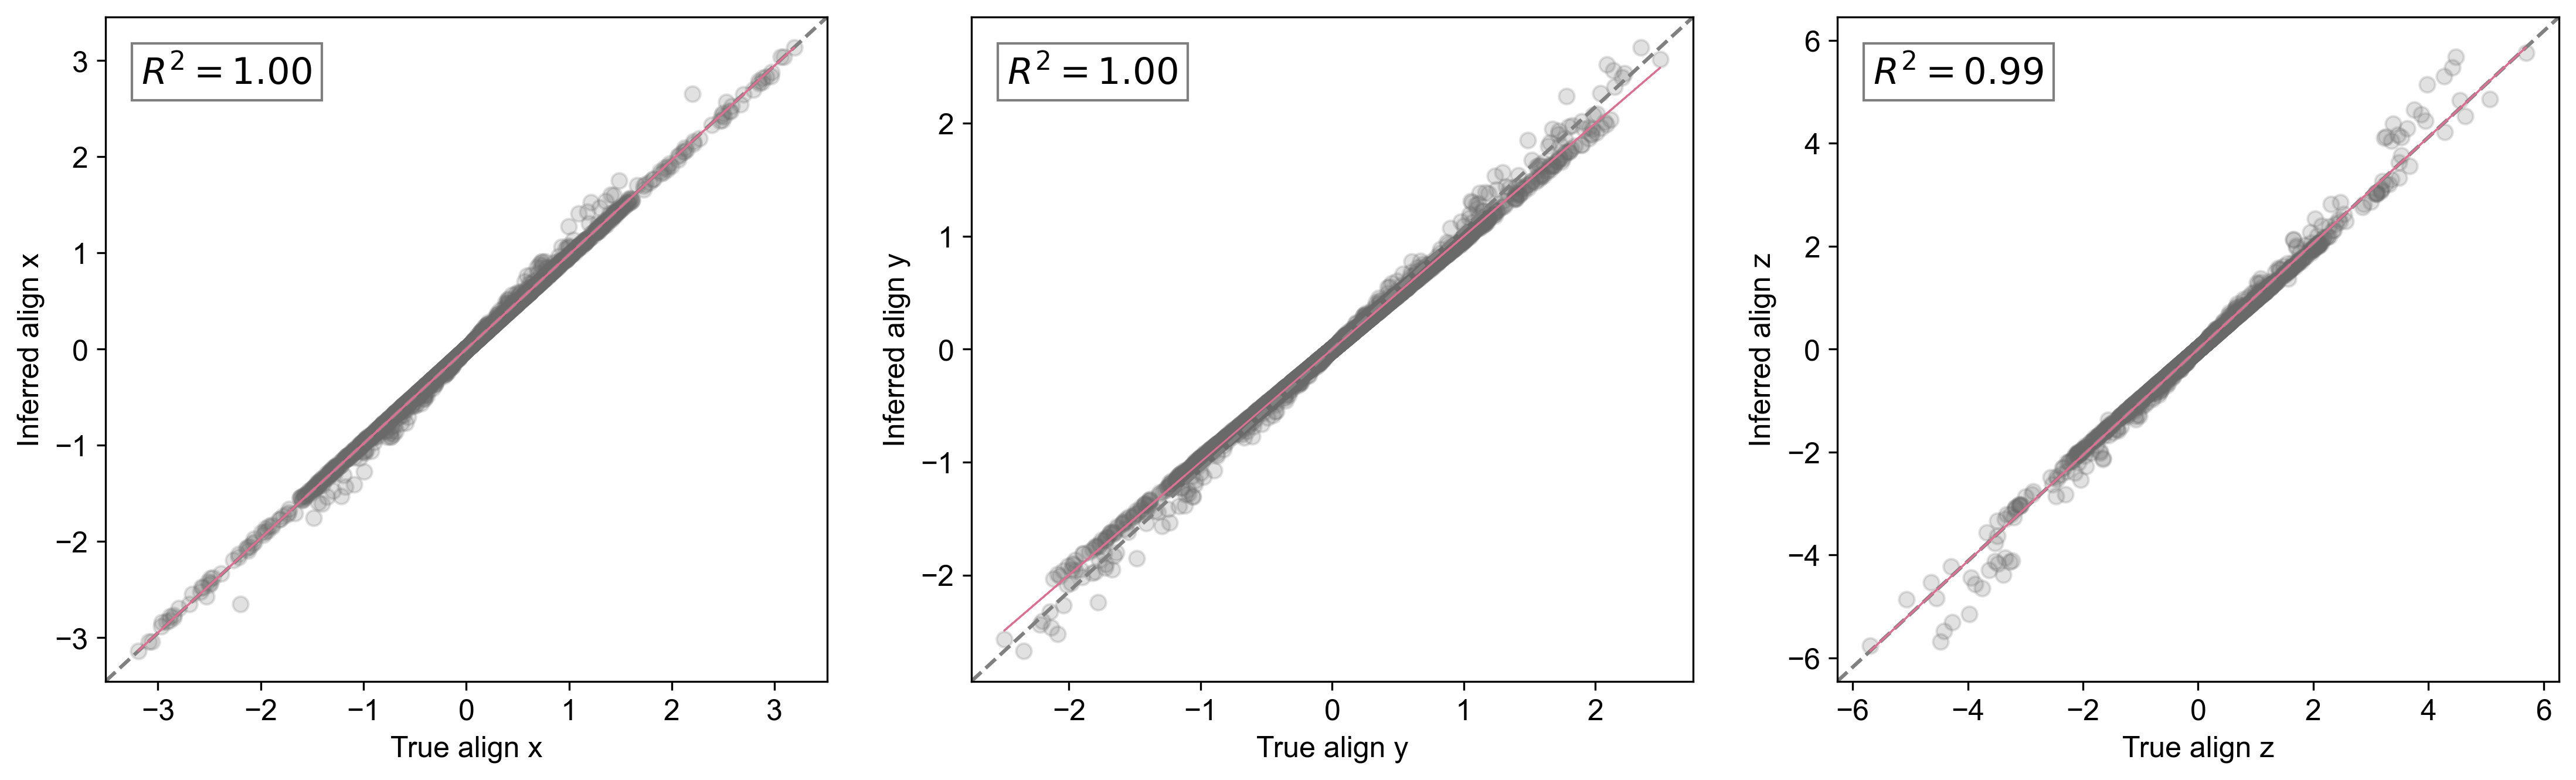

In [639]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sx = bestMe['a1'].values
sx_true = align_true*bestMe['dxij']
sy = bestMe['a2'].values
sy_true = align_true*bestMe['dyij']
sz = bestMe['a3'].values
sz_true = align_true*bestMe['dzij']
sx = sx[0:5000]
sx_true = sx_true[0:5000]
sy = sy[0:5000]
sy_true = sy_true[0:5000]
sz = sz[0:5000]
sz_true = sz_true[0:5000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=40,c ='dimgrey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='grey', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=0.75)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True align x")
plt.ylabel("Inferred align x")

ax2 = fig.add_subplot(1,3,2)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=40,c ='dimgrey', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='grey', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c='palevioletred',lw=0.75)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True align y")
plt.ylabel("Inferred align y")


ax3 = fig.add_subplot(1,3,3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=40,c ='dimgrey', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='grey', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fz(sz_true),c='palevioletred',lw=0.75)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=15, bbox=bbox)
plt.xlabel("True align z")
plt.ylabel("Inferred align z")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/vicsek_model/Figures/vicsek_align_fig.pdf')

In [630]:
from sklearn.linear_model import LinearRegression 
sx_true = np.exp(-rij_val/3)*bestMe['dyij'].values
goal = bestMe['a2'].values.reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['a2'])
y = goal.copy()
Xfind = sx_true.values.reshape(-1,1)
yfind = y['a2']
model_linear = LinearRegression(fit_intercept=False)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_
print(a)

[0.98381096]


In [614]:
best_selfDyn = selfDyn_over_time[-1]
best_selfDyn = pd.DataFrame(best_selfDyn)
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)

In [615]:
best_selfDyn

,dxi,dyi,dzi,s1
0,-0.235283,-1.276551,0.159030,0.801593
1,-0.235283,-1.276551,0.159030,0.801593
2,-0.235283,-1.276551,0.159030,0.801593
3,-0.235283,-1.276551,0.159030,0.801593
4,-0.235283,-1.276551,0.159030,0.801593
...,...,...,...,...
379995,-0.220605,-0.011965,0.664225,3.373625
379996,-0.220605,-0.011965,0.664225,3.373625
379997,-0.220605,-0.011965,0.664225,3.373625
379998,-0.220605,-0.011965,0.664225,3.373625


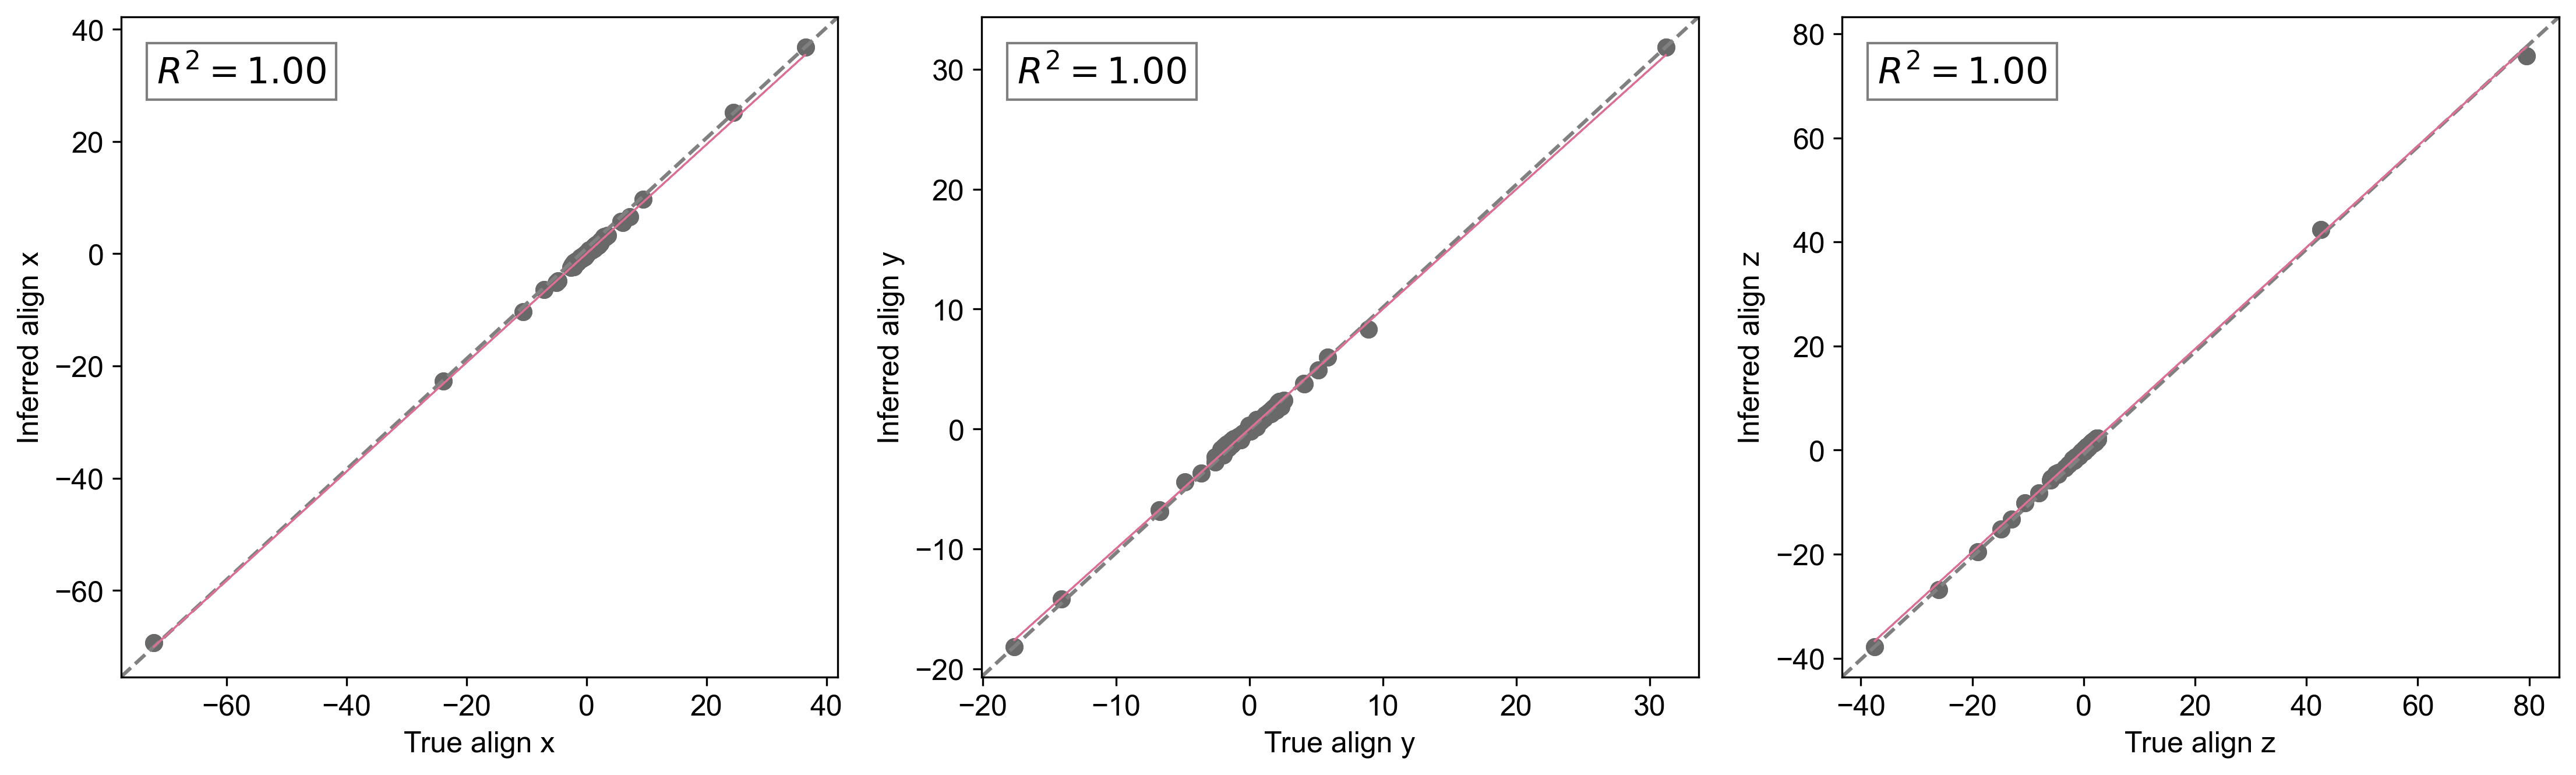

In [642]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

sx = best_selfDyn['s1'].values*best_selfDyn['dxi'].values
sx_true = 2*(1.5**2-(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2+best_selfDyn['dzi']**2))*best_selfDyn['dxi'].values
sy = best_selfDyn['s1'].values*best_selfDyn['dyi'].values
sy_true = 2*(1.5**2-(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2+best_selfDyn['dzi']**2))*best_selfDyn['dyi'].values
sz = best_selfDyn['s1'].values*best_selfDyn['dzi'].values
sz_true = 2*(1.5**2-(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2+best_selfDyn['dzi']**2))*best_selfDyn['dzi'].values
sx = sx[0:5000]
sx_true = sx_true[0:5000]
sy = sy[0:5000]
sy_true = sy_true[0:5000]
sz = sz[0:5000]
sz_true = sz_true[0:5000]
fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=40,c ='dimgrey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='grey', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=0.75)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True align x")
plt.ylabel("Inferred align x")

ax2 = fig.add_subplot(1,3,2)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=40,c ='dimgrey', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='grey', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c='palevioletred',lw=0.75)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True align y")
plt.ylabel("Inferred align y")


ax3 = fig.add_subplot(1,3,3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=40,c ='dimgrey', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='grey', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fz(sz_true),c='palevioletred',lw=0.75)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=15, bbox=bbox)
plt.xlabel("True align z")
plt.ylabel("Inferred align z")

plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/vicsek_model/Figures/vicsek_self_fig.pdf')

In [631]:
from sklearn.linear_model import LinearRegression 
sx_true = best_selfDyn['dxi']**2+best_selfDyn['dyi']**2+best_selfDyn['dzi']**2
goal = best_selfDyn['s1'].values.reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['s1'])
y = goal.copy()
Xfind = sx_true.values.reshape(-1,1)
yfind = y['s1']
model_linear = LinearRegression(fit_intercept=True)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_
print(a)
model_linear.intercept_

[-1.9350693]


4.27362

In [ ]:
!pip3 install gplearn

In [ ]:
import gplearn as gp
from gplearn.genetic import SymbolicRegressor

In [ ]:
X_reg = best_selfDyn.iloc[:,0:3]
y_reg = best_selfDyn['s2']
est_gp = SymbolicRegressor(population_size=2000,
                           generations=20, stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           function_set=('add', 'mul', 'div','sub'),
                           parsimony_coefficient=0.0001, random_state=0)
est_gp.fit(X_reg, y_reg)

In [ ]:
est_gp.fit(X_reg,y_reg)

In [ ]:
print(est_gp._program)

In [ ]:
est_gp.score(X_reg,y_reg)